In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [3]:
figdir='/mnt/home/szheng/ceph/place_variability/fig/paper/figure_block_reuse'
figdir= misc.get_or_create_subdir(figdir)

In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
import unimodal_nmf as unmf

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [24]:
import reuse_block_analysis as rba

In [6]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=False,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 333 ms, sys: 7.58 s, total: 7.91 s
Wall time: 46.2 s


In [7]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column

fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')

frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [8]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


In [49]:
region='CA1'
exp=0
uid=82#64
isnovel=0
get_field_day=3

In [50]:
# exp_ind=('CA1',slice(None),0)
# per_cell_metrics_oneexp = per_cell_metrics.loc[exp_ind,:]
# row=per_cell_metrics_oneexp.query('si>1').sample(1,random_state=3)
# print(row)
# region, exp, day,isnovel,uid=ind=row.index[0]
# uid=40
# region,exp = exp_ind

# region = 'CA1'#'CA3'
# exp = 0#0
# uid = 64#21
# isnovel = 0#1

# prep all days
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
# X_df_ = X_df_.fillna(axis=0,method='ffill')
# maxval = np.quantile(X_df_.dropna(),0.99)
# X_df_[X_df_ > maxval] = X_df_

# get_field_day = 3
compare_day = 0#2

# X_df_compare = X_df_.loc[:,[compare_day]]

X_df_field = X_df_.loc[:,[get_field_day]] # 
# X_df_field = X_df_# X_df_.loc[:,X_df_.columns.get_level_values(0)!=2] #
# norm_factor = np.quantile(X_df_field.dropna().values,0.99)
# X_df = X_df_field /norm_factor
X_df = X_df_field

reload(unmf)
n_basis = 20#20#20
# lam_beta=lam_beta_cross=20
lam_beta=lam_beta_cross=20.#20.

# lam_beta=lam_beta_cross = 20.#1.
lam_h = 0.1
rtol=1e-3
# lam_beta_cross = 10.#0.1
norm_W='mean' # 'max'
W_hat_ma, H_hat_ma,X_hat, loss_history = unmf.do_unimodal_nmf_wrapper(X_df,ma_thresh=0.05,clip_ratio=0.99,
                                                                n_components=n_basis,lam_beta=lam_beta,lam_h=lam_h,lam_beta_cross=lam_beta_cross,
                                                                n_basis=n_basis,
                                                                n_iter_max=100,rtol=rtol,
                                                                verbose=True,norm_H=None,norm_W=norm_W
                                                               )

recon = loss_history['reconstruction'].iloc[-1]

field_range=rba.get_field(W_hat_ma,extend=2,max_thresh=0.2,out_of_field_size_thresh=5)


iter0--tot: 173.05214, recon: 51.79463, reg_beta: 0.43695, reg_H: 7.65500, reg_beta_cross: 113.16556
iter1--tot: 386.62493, recon: 28.99488, reg_beta: 2.25696, reg_H: 9.30180, reg_beta_cross: 346.07129
iter2--tot: 327.82391, recon: 28.97091, reg_beta: 2.19319, reg_H: 9.23116, reg_beta_cross: 287.42865
iter3--tot: 325.18912, recon: 29.00474, reg_beta: 2.17223, reg_H: 9.26413, reg_beta_cross: 284.74802
iter4--tot: 324.69470, recon: 29.01599, reg_beta: 2.16795, reg_H: 9.26902, reg_beta_cross: 284.24174
iter5--tot: 324.60298, recon: 29.01843, reg_beta: 2.16705, reg_H: 9.26979, reg_beta_cross: 284.14771
success=True


/mnt/home/szheng/projects/nmf_analysis/unimodal_nmf.py:394: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


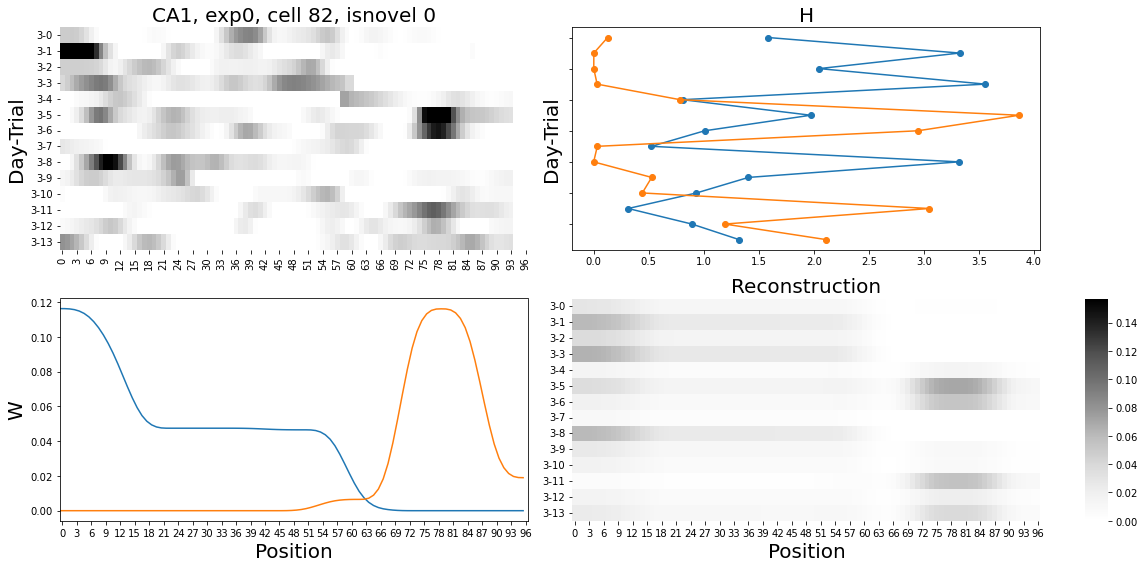

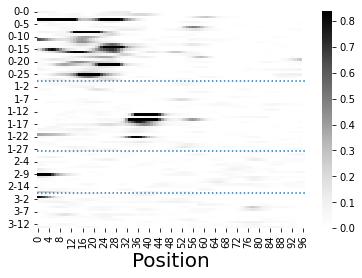

In [51]:
reload(unmf)
dosave = False
fig=unmf.plot_ratemap_and_wh(X_df_field,W_hat_ma,H_hat_ma,X_hat=X_hat,
                                region=region,exp=exp,isnovel=isnovel,uid=uid)


if dosave:
    for fmt in ['svg','png']:
        fig_fn = f'good_ex_{region}_exp{exp}_uid{uid}_isnovel{isnovel}_day{get_field_day}_unmf.{fmt}'
        fig_fn_full=os.path.join(figdir,fig_fn)
        fig.savefig(fig_fn_full,bbox_inches='tight')
fig,ax=ph.heatmap(X_df_.T)
fig,ax=ph.plot_day_on_heatmap(X_df_.T,ax=ax,fig=fig)
if dosave:
    for fmt in ['svg','png']:
        fig_fn = f'good_ex_{region}_exp{exp}_uid{uid}_isnovel{isnovel}_allday.{fmt}'
        fig_fn_full=os.path.join(figdir,fig_fn)
        fig.savefig(fig_fn_full,bbox_inches='tight')
